In [1]:
import sys, os
os.path.dirname(sys.executable)

'/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/bin'

In [2]:
sys.path.append('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/')
from ESMCBA.imports import *
from ESMCBA import graph_utils
from ESMCBA import other_utils
import importlib
importlib.reload(other_utils)

<module 'ESMCBA.other_utils' from '/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/ESMCBA/other_utils.py'>

In [41]:
def classify(name):
    name_lower = name.lower()
    if 'virus' in name_lower:
        return 'virus'
    elif 'mycobacterium' in name_lower:
        return 'bacterium'
    else:
        return 'other'

# Get all matching CSV files in the folder (here limiting to first 10 for example)
file_list = glob.glob('/global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_*_final.csv')

# Dictionary to store the counts per file
counts_by_file = {}

all_hlas = pd.DataFrame()

for file in file_list:
    try:
        # Read file; if empty, skip it.
        df = pd.read_csv(file, header=None)
        df['HLA'] = file.split('/global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_')[1].split('_final.csv')[0]
        all_hlas = pd.concat([all_hlas, df])
        if df.empty:
            print(f"Skipping empty file: {file}")
            continue
    except pd.errors.EmptyDataError:
        print(f"Skipping empty file (error): {file}")
        continue

    # Filter rows: Column 7 must not be NA and Column 8 must contain 'Positive'
    df_filtered = df[(df[7].notna()) ] #& (df[8].str.contains('Positive'))]
    
    # Select only HLA allele (column 0) and species name (column 6) then drop duplicates
    df_filtered = df_filtered[[0, 6]].drop_duplicates()
    df_filtered.columns = ['hla', 'name']
    
    # Create a new column with the category classification
    df_filtered['category'] = df_filtered['name'].apply(classify)
    
    # Count the occurrences per category in this file
    category_counts = df_filtered['category'].value_counts()
    
    # Use the basename of the file as the column key
    file_key = os.path.basename(file)
    counts_by_file[file_key] = category_counts

# Combine the counts from all files into a single DataFrame,
# with rows as categories and columns as file names.
aggregated_table = pd.DataFrame(counts_by_file).fillna(0).astype(int)

Skipping empty file (error): /global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLAB5502_final.csv
Skipping empty file (error): /global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLADQ6_final.csv
Skipping empty file (error): /global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLADQA10101DQB10503_final.csv
Skipping empty file (error): /global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLAB0801BI66Amutant_final.csv
Skipping empty file (error): /global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLADRB11305_final.csv
Skipping empty file (error): /global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLADPB11501_final.csv
Skipping empty file (error): /global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLAA0208_final.csv
Skipping empty file (error): /global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLADPB11101_final.csv
Skipping empty file (error): /global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLAA0201K66A,E63Qmutant_final.csv
Skipping empty file (error): /global/scratch/us

In [5]:
aggregated_table.columns = [x.split('_')[1] for x in aggregated_table.columns]

In [6]:
aggregated_table

,HLADRB10701,HLAA1,HLADQA10501DQB10303,HLAB39,HLADPB10501,HLADRB10404,HLADRB40101,HLADRB10303,HLAA2601,HLAA3101,...,HLADQA10303DQB10402,HLAA2,HLADRB10801,HLAB1302,HLADQA10102DQB10604,HLAA0201,HLADR14,HLA-DQB1*05:01,HLAB58,HLAA0203
category,,,,,,,,,,,,,,,,,,,,,
bacterium,115,0,0,0,0,74,132,0,85,124,...,0,16,5,0,0,274,21,0,0,33
other,2248,4,564,2,160,909,1725,46,2135,2380,...,567,67,126,2,61,6889,70,158,1,2311
virus,931,11,0,3,1,483,479,0,1023,2235,...,0,17,31,1,0,7325,0,1,5,3251


In [7]:
aggregated_table.T.sort_values('virus', ascending=False).head(20)

category,bacterium,other,virus
HLAA0201,274,6889,7325
HLADRB10101,131,5516,3418
HLAA6802,40,2394,3312
HLAA0203,33,2311,3251
HLAA0206,19,1944,3066
HLAA0202,0,1611,2782
HLAA0301,113,3457,2693
HLAA1101,119,2771,2660
HLAA3101,124,2380,2235
HLAA6801,20,1248,1760


In [8]:
aggregated_table_subset = aggregated_table[['HLAA1101', 'HLAB3901', 'HLAA3001', 'HLAA0203', 'HLAA0206',
       'HLAB3501', 'HLAA0202', 'HLAA6801', 'HLAA2301', 'HLAB5801',
       'HLAA2403', 'HLAB1517', 'HLAA3002', 'HLAA6802', 'HLAA3301',
       'HLAB0702', 'HLAA0201', 'HLAA2902', 'HLAB1501', 'HLAB0801',
       'HLAA0301', 'HLAB4402', 'HLAA2402', 'HLAA6901', 'HLAA0101',
       'HLAA2601', 'HLAB5701', 'HLAB1801', 'HLAB5101', 'HLAB4601']]

In [9]:
aggregated_table_subset = aggregated_table_subset.T.sort_values('virus', ascending=False).T

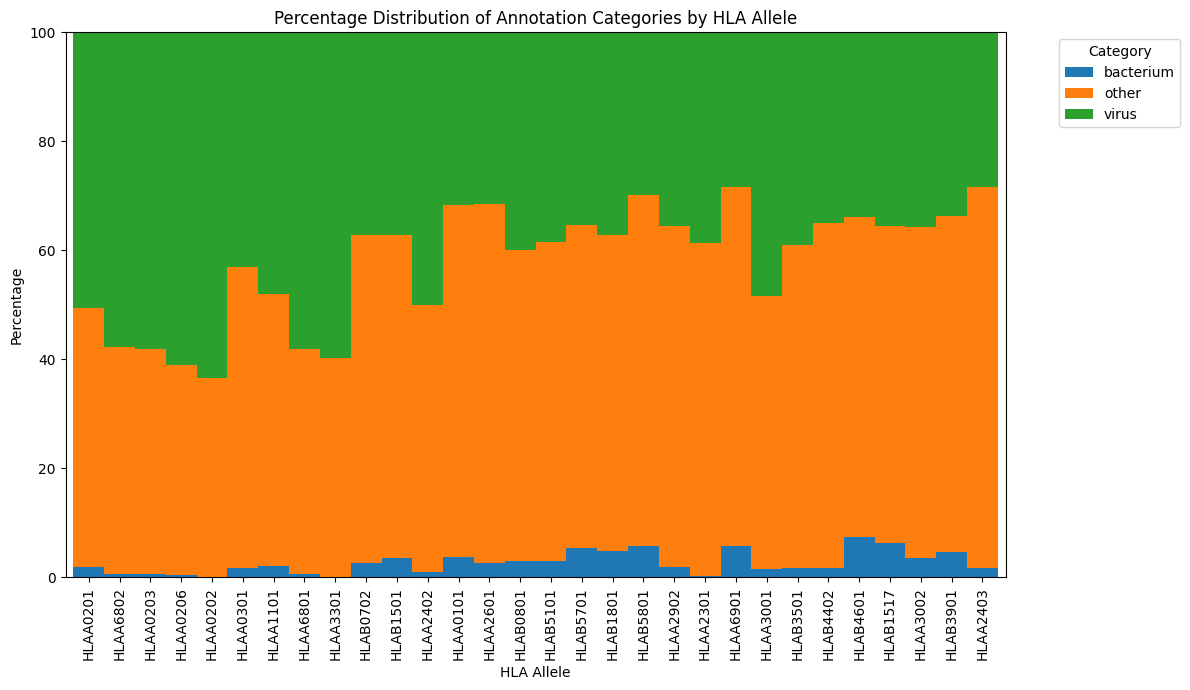

In [10]:
import matplotlib.pyplot as plt

# Remove columns where the sum of counts (across all categories) is zero
aggregated_table_subset_filtered = aggregated_table_subset.loc[:, aggregated_table_subset.sum(axis=0) != 0]

# Convert counts to percentages per HLA allele (per column)
percent_table = aggregated_table_subset_filtered.div(aggregated_table_subset_filtered.sum(axis=0), axis=1) * 100

# Create the stacked bar graph with width=1 (removes gaps between bars)
fig, ax = plt.subplots(figsize=(12, 7))
percent_table.T.plot(kind='bar', stacked=True, ax=ax, width=1)

# Remove borders between bar segments
for patch in ax.patches:
    patch.set_linewidth(0)
    patch.set_edgecolor('none')

# Set axis labels and title
ax.set_xlabel("HLA Allele")
ax.set_ylabel("Percentage")
ax.set_title("Percentage Distribution of Annotation Categories by HLA Allele")
ax.set_ylim(0, 100)
# ax.set_xticklabels([])

# Position the legend outside of the plot area
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [11]:
aggregated_table_subset

,HLAA0201,HLAA6802,HLAA0203,HLAA0206,HLAA0202,HLAA0301,HLAA1101,HLAA6801,HLAA3301,HLAB0702,...,HLAA2301,HLAA6901,HLAA3001,HLAB3501,HLAB4402,HLAB4601,HLAB1517,HLAA3002,HLAB3901,HLAA2403
category,,,,,,,,,,,,,,,,,,,,,
bacterium,274,40,33,19,0,113,119,20,0,96,...,6,136,21,29,30,123,88,49,62,22
other,6889,2394,2311,1944,1611,3457,2771,1248,1157,2226,...,1055,1545,681,971,1148,986,819,816,831,851
virus,7325,3312,3251,3066,2782,2693,2660,1760,1721,1376,...,668,665,658,639,634,567,500,482,455,345


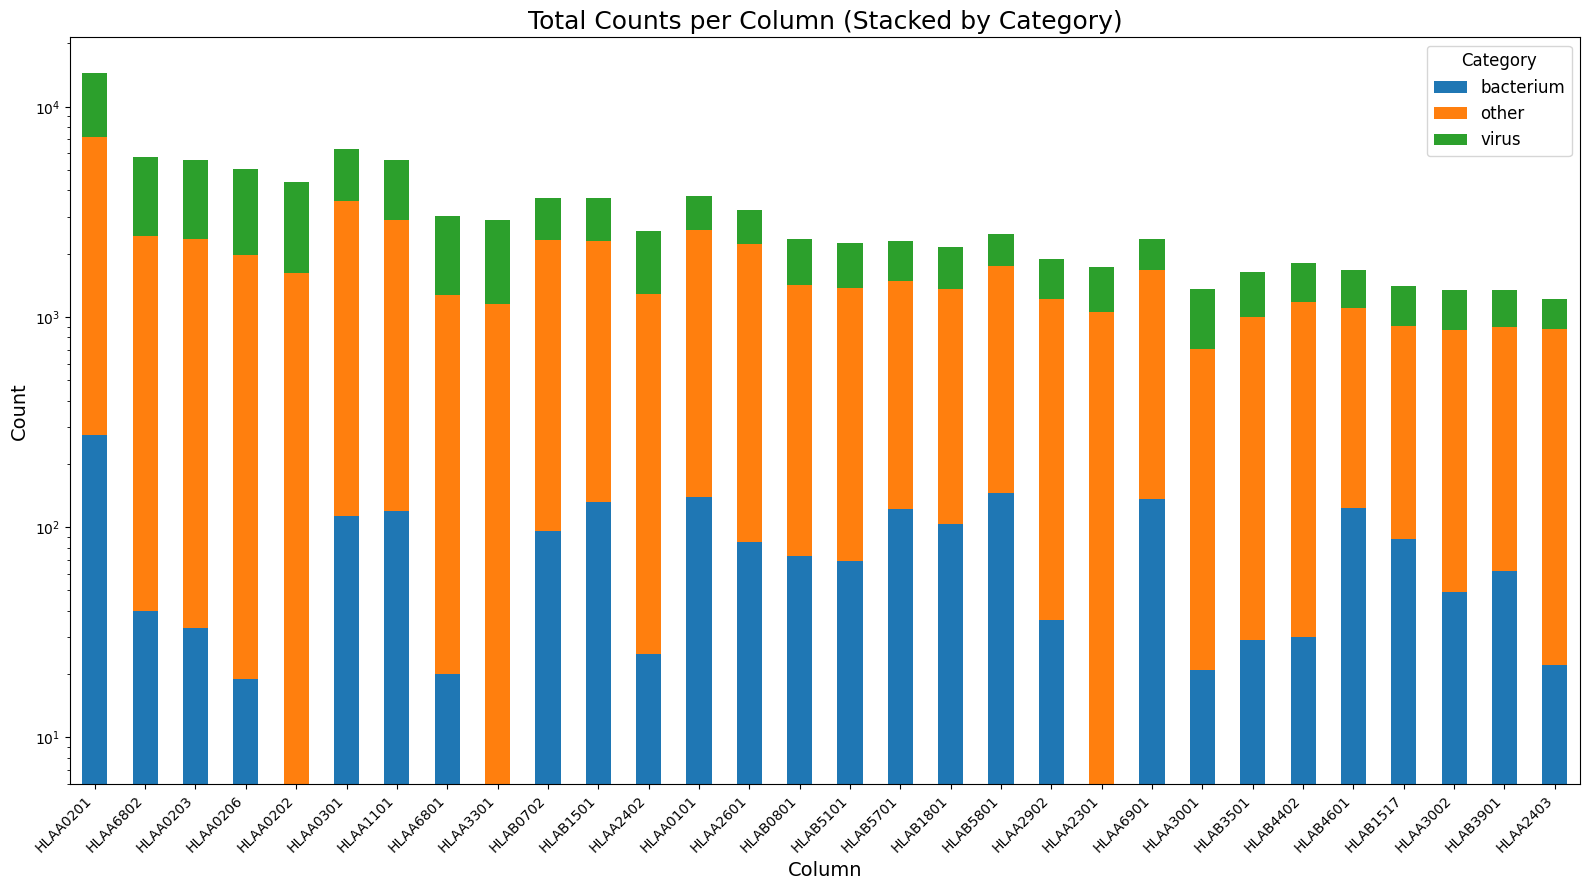

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))

# Create the stacked bar plot.
aggregated_table_subset.T.plot(kind='bar', stacked=True, ax=ax)

# Set the title and axis labels.
ax.set_title("Total Counts per Column (Stacked by Category)", fontsize=18)
ax.set_xlabel("Column", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.legend(title="Category", fontsize=12, title_fontsize=12)


plt.yscale('log')
# Rotate the x-tick labels for readability.
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [48]:
all_hlas[9] = all_hlas[9].astype('str')
all_hlas[9] = all_hlas[9].replace(r'\N', 0)
all_hlas[9] = all_hlas[9].astype('float')

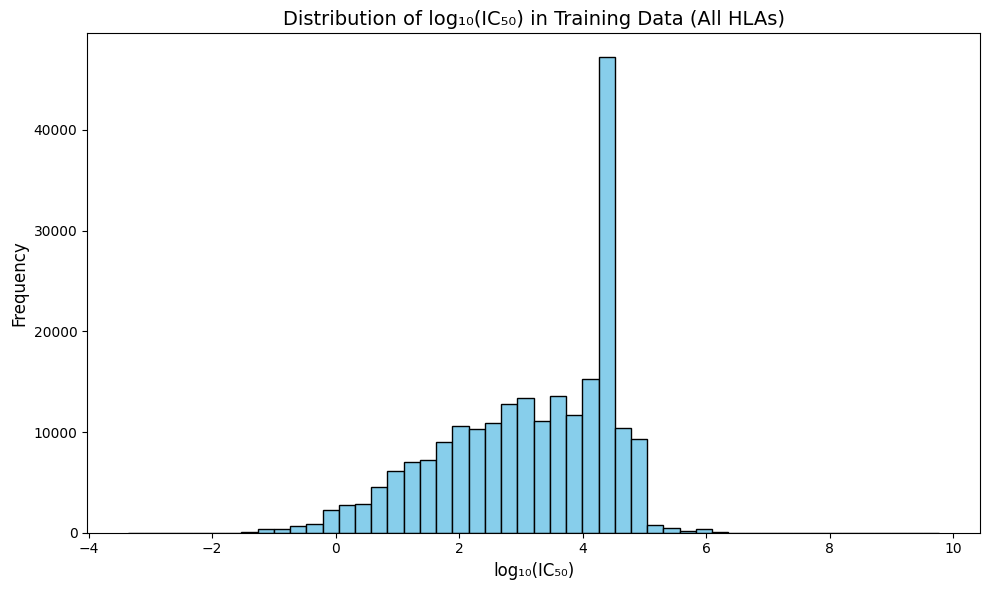

/tmp/ipykernel_869434/2395572855.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=9, y='log_IC50', data=all_hlas_violin, inner='quartile', palette='pastel')


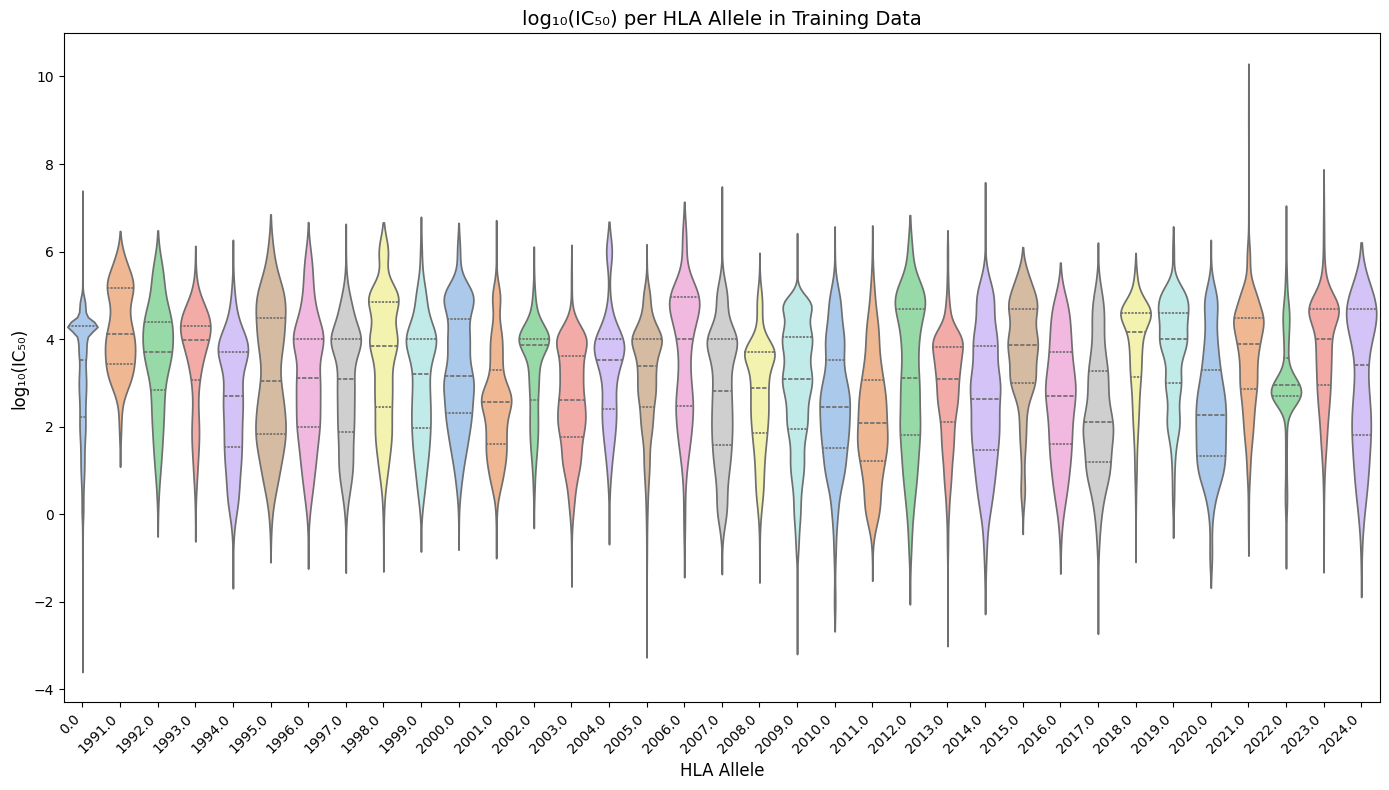

In [51]:
all_hlas[7] = pd.to_numeric(all_hlas[7], errors='coerce')
all_hlas['log_IC50'] = np.log10(all_hlas[7])

# ------------------------------
# Option 1: Aggregated Histogram
# ------------------------------
plt.figure(figsize=(10, 6))
plt.hist(all_hlas['log_IC50'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.xlabel('log₁₀(IC₅₀)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of log₁₀(IC₅₀) in Training Data (All HLAs)', fontsize=14)
plt.tight_layout()
plt.show()

# ------------------------------
# Option 2: Violin Plots per HLA Allele
# ------------------------------
# Assume column 9 holds the HLA allele information.
# all_hlas['HLA'] = all_hlas[9]

# Remove rows with missing HLA or log_IC50 values.
all_hlas_violin = all_hlas.dropna(subset=['HLA', 'log_IC50'])

plt.figure(figsize=(14, 8))
sns.violinplot(x=9, y='log_IC50', data=all_hlas_violin, inner='quartile', palette='pastel')
plt.xlabel('HLA Allele', fontsize=12)
plt.ylabel('log₁₀(IC₅₀)', fontsize=12)
plt.title('log₁₀(IC₅₀) per HLA Allele in Training Data', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()